In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
#creating training data
DATADIR = '../../../image_dataset_anomaly_detection/train'
DATADIR_test = '../../../image_dataset_anomaly_detection/test'
CATEGORIES = ['normal', 'anomaly']

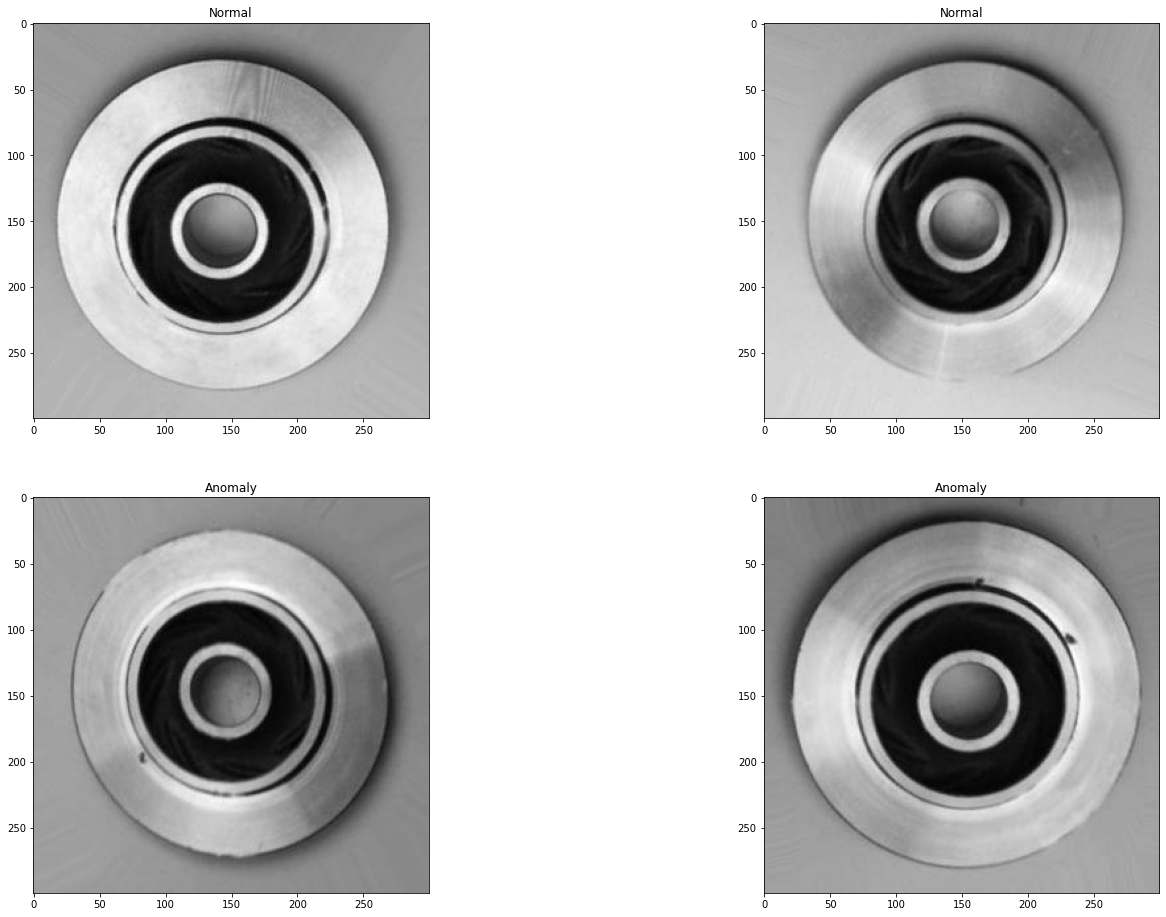

In [3]:
plt.figure(figsize=(24,16))
idx = 0
for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    for img in os.listdir(path)[:2]:
        plt.subplot(2,2,idx+1)
        img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
        plt.title('Anomaly' if category == 'anomaly' else 'Normal')
        plt.imshow(img_array,cmap='gray')
        idx += 1
        if idx == 4:
          break

In [4]:
print(img_array)

[[150 150 150 ... 181 181 181]
 [150 150 150 ... 181 181 181]
 [150 150 149 ... 181 181 181]
 ...
 [176 176 176 ... 201 201 202]
 [176 176 176 ... 201 201 201]
 [176 176 176 ... 200 201 201]]


In [5]:
img_array.shape

(300, 300)

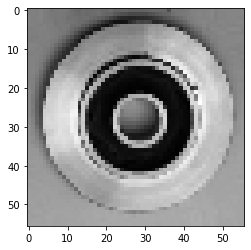

In [6]:
IMG_SIZE = 56

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap = 'gray')
plt.show()

# Preprocess Data

In [19]:
def preprocess_data_vae(X_train):
  X_train = X_train.astype('float32')
  X_train -= 127.5
  X_train /= 127.5

  return X_train

# Import Additional Libraries

In [4]:
import keras
from keras.layers import Input, Conv2D, UpSampling2D, MaxPooling2D, Dense, Conv2DTranspose, Flatten, GlobalAveragePooling2D, Reshape, Activation, add, concatenate, Dropout
from keras.models import Model, Sequential
from keras import optimizers
import keras.utils
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint
from PIL import Image
from keras import backend as K

from tensorflow import keras
import datetime
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Image Augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

#Create image augmentation
augmentation_generator = ImageDataGenerator(horizontal_flip=True, # Randomly flip images
                                  vertical_flip=True, # Randomly flip images
                                  rotation_range = 20, 
                                  brightness_range=(0.5,1.5),
                                  preprocessing_function=preprocess_data_vae) #Randomly rotate

# augmentation_generator.fit(X)
train_iterator = augmentation_generator.flow_from_directory(DATADIR, target_size=(56,56), color_mode='grayscale', batch_size=32, class_mode='input', classes=['normal'])
validation_iterator = augmentation_generator.flow_from_directory(DATADIR_test, target_size=(56,56), color_mode='grayscale', batch_size=8, class_mode='input', classes=['normal'])

# TensorBoard

In [14]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Variational AutoEncoder (VAE)

https://github.com/unnir/cVAE

https://arxiv.org/pdf/2010.05531.pdf

In [28]:
model_used = 'VAE'

initializer = keras.initializers.RandomNormal(mean=0., stddev=0.3)

def variational_autoencoder(input_img, labels, size):
    reshape1 = Reshape(target_shape=(size[0]*size[1],))(input_img)
    # encoder
    encoder_input = Dense(1024, activation='leaky_relu', input_shape=(size[0]*size[1],))(reshape1)
    h = Dense(512, activation='leaky_relu')(encoder_input)
    h = Dense(256, activation='leaky_relu')(h)
    encoder_output = Dense(256, activation='leaky_relu')(h)
    
    encoder_output = concatenate([encoder_output, labels])
    
    mean, sigma = Dense(10)(encoder_output), Dense(10, kernel_initializer=initializer)(encoder_output)
    
    encoder_output_z = mean + keras.activations.exponential(0.5*sigma)
    
    encoder_output = concatenate([encoder_output_z, labels])

    # decoder
    decoder_input = Dense(256, activation='leaky_relu')(encoder_output)
    h = Dense(256, activation='leaky_relu')(decoder_input)
    h = Dense(512, activation='leaky_relu')(h)
    h = Dense(1024, activation='leaky_relu')(h)
    decoded = Dense(size[0]*size[1], activation='leaky_relu')(h)
    reshape2 = Reshape(target_shape=(size[0], size[1], 1))(decoded)

    return reshape2, encoder_output_z

## Training the Model

In [29]:
from __future__ import print_function
from keras.models import load_model

batch_size = 32
num_classes = 1
epochs = 80

img_rows, img_cols = 56,56

if K.image_data_format() == 'channels_first':
    # x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    # x_val = x_val.reshape(x_val.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    # x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols)
    # x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols)
    input_shape = (img_rows, img_cols, 1)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = keras.callbacks.TensorBoard(logdir, histogram_freq=1)

early_stop = EarlyStopping(monitor='loss', min_delta=0.001, patience=3, mode='min', verbose=1)

input_img = Input(shape=(IMG_SIZE,IMG_SIZE,))
labels_img = Input(shape=(1,))
model = Model(inputs=[input_img, labels_img], outputs=variational_autoencoder(input_img, labels_img, (IMG_SIZE,IMG_SIZE)))
checkpoint = ModelCheckpoint('model_best_weights_anomaly_detection_vae_designed.h5', monitor='loss', verbose=1, save_best_only=True, mode='min', period=1)
model.compile(loss=[keras.losses.mean_squared_error],
            optimizer=keras.optimizers.Adam(learning_rate=0.0009, decay=1e-6))

model_train = model.fit(training_generator,
        epochs=epochs,
        verbose=1,
        max_queue_size=100,
        validation_data=validation_generator,
        callbacks=[tensorboard_callback,early_stop,checkpoint])

Training shape:  (64, 56, 56, 1)
Epoch 1/80
206/207 [============================>.] - ETA: 0s - loss: 0.1738 - reshape_3_loss: 0.1738WARNING:tensorflow:Model was constructed with shape (None, 56, 56) for input KerasTensor(type_spec=TensorSpec(shape=(None, 56, 56), dtype=tf.float32, name='input_3'), name='input_3', description="created by layer 'input_3'"), but it was called on an input with incompatible shape (None, None, None, None).

Epoch 00001: loss improved from inf to 0.17346, saving model to model_best_weights_anomaly_detection_vae_designed.h5
207/207 [==============================] - 11s 53ms/step - loss: 0.1735 - reshape_3_loss: 0.1735 - val_loss: 0.1049 - val_reshape_3_loss: 0.1049
Epoch 2/80
206/207 [============================>.] - ETA: 0s - loss: 0.0936 - reshape_3_loss: 0.0936
Epoch 00002: loss improved from 0.17346 to 0.09357, saving model to model_best_weights_anomaly_detection_vae_designed.h5
207/207 [==============================] - 11s 53ms/step - loss: 0.0936 - 

In [36]:
input_CATEGORIES = ['anomaly']
testing_data = []
def create_testing_data():
    for category in input_CATEGORIES:
        path_test = os.path.join(DATADIR_test, category)
        class_num = CATEGORIES.index(category)
        for img in tqdm(os.listdir(path_test)):
            img_array = cv2.imread(os.path.join(path_test,img),cv2.IMREAD_GRAYSCALE)
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            testing_data.append([new_array,class_num])

create_testing_data()

X_test = []
y_test= []

for features,label in tqdm(testing_data):
    X_test.append(features)
    y_test.append(label)
    
X_test = np.array(X_test).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

score = model.evaluate(X_test[:64], X_test[:64], verbose=0)

print('Test loss: ', score[0])
print('Test SSIMError: ', score[1])
print('Test SSIM Difference: ', 1 - score[1])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:00<00:00, 1733594.63it/s]


Test loss:  11628.259765625
Test SSIMError:  0.0016881858464330435
Test SSIM Difference:  0.998311814153567


In [44]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 2617568), started 0:01:37 ago. (Use '!kill 2617568' to kill it.)

In [45]:
!kill 2617568

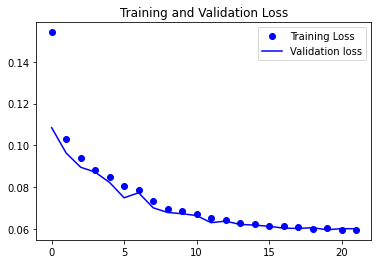

In [97]:
loss = model_train.history['loss']
val_loss = model_train.history['val_loss']
epochs = list(range(22))
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [99]:
model_train.history.keys()

dict_keys(['loss', 'reshape_38_loss', 'val_loss', 'val_reshape_38_loss'])

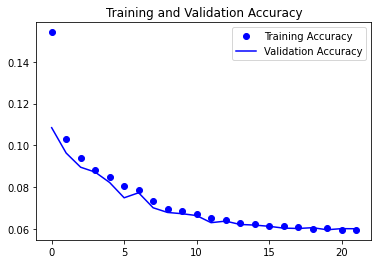

In [100]:
loss = model_train.history['reshape_38_loss']
val_loss = model_train.history['val_reshape_38_loss']
epochs = list(range(22))
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Accuracy')
plt.plot(epochs, val_loss, 'b', label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

In [101]:
model.save('model_best_weights_anomaly_detection_vae_designed_completion.h5')

Test image
Predicted image
[[-0.5719284  5.2181673]]


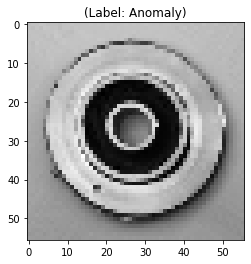

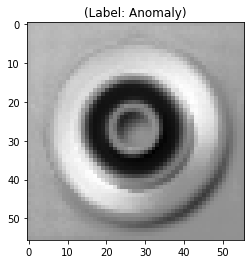

In [12]:
from keras.models import load_model
from glob import glob

vae_model = load_model('../vae/model_best_weights_anomaly_detection_vae_designed_completion.h5')

label = 2

path = os.path.join(DATADIR_test, 'anomaly')

test_X = cv2.resize(cv2.imread(glob(path + "/*")[label], cv2.IMREAD_GRAYSCALE), (56,56))
test_Y = 'Anomaly'
test_X = (test_X.reshape(-1,56,56)-127.5)/127.5
pred, z = vae_model.predict([test_X, np.array([1]).reshape(-1,1)])

plt.figure(figsize=(20,4))
print("Test image")
plt.imshow(test_X.reshape(56,56), cmap='gray')
curr_lbl = test_Y
plt.title("(Label: " + str(curr_lbl) + ")")

plt.figure(figsize=(20,4))
print("Predicted image")
plt.imshow(pred.reshape(56,56), cmap='gray')
curr_lbl = test_Y
plt.title("(Label: " + str(curr_lbl) + ")")
print(z)
# print(SSIMError(test_X.reshape(-1,56,56,1).astype(np.float32), pred.reshape(-1,56,56,1).astype(np.float32)))
    
plt.show()

In [24]:
vae_model = load_model("../vae/model_best_weights_anomaly_detection_vae_designed_completion.h5")

anomaly_scores = {0: [], 1: []}

for label in tqdm(range(0,len(X_test))):
    test_X = X_test[label]
    test_Y = y_test[label]
    test_X = (test_X.reshape(-1,56,56,1)-127.5)/127.5
    pred, z = vae_model.predict([test_X, np.array([test_Y]).reshape(-1,1)])

    anomaly_scores[test_Y].append(z)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 715/715 [01:10<00:00, 10.18it/s]


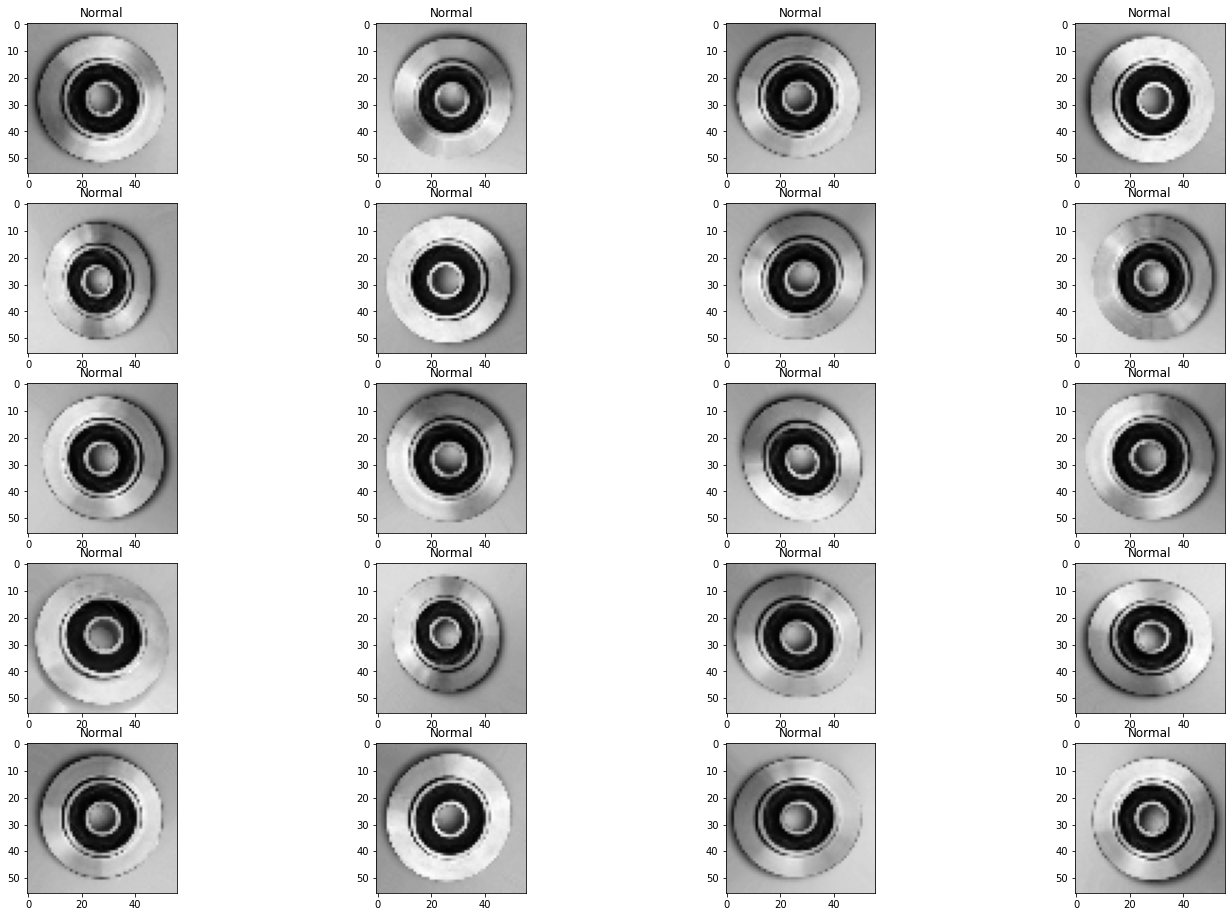

In [64]:
plt.figure(figsize=(24,16))
idx = 0
for label, img in enumerate(X_test[:20]):
    plt.subplot(5,4,idx+1)
    plt.title('Anomaly' if y_test[label] == 1 else 'Normal')
    plt.imshow(img,cmap='gray')
    idx += 1

# Normal/Anomaly Images Set in Comparison with Input Image

In [105]:
# our set is
anomaly_z_list = anomaly_scores[0][0:80]
kld_test_normal = []
for i in range(len(anomaly_z_list)):
    kld_array_normal = []
    for j in range(100,120):
        kld = keras.metrics.kl_divergence(anomaly_scores[0][j], anomaly_z_list[i])
        kld_array_normal.append(kld)
    kld_test_normal.append(kld_array_normal)
    
anomaly_z_list = anomaly_scores[1][0:80]
kld_test_anomaly = []
for i in range(len(anomaly_z_list)):
    kld_array_anomaly = []
    for j in range(100,120):
        kld = keras.metrics.kl_divergence(anomaly_scores[0][j], anomaly_z_list[i])
        kld_array_anomaly.append(kld)
    kld_test_anomaly.append(kld_array_anomaly)

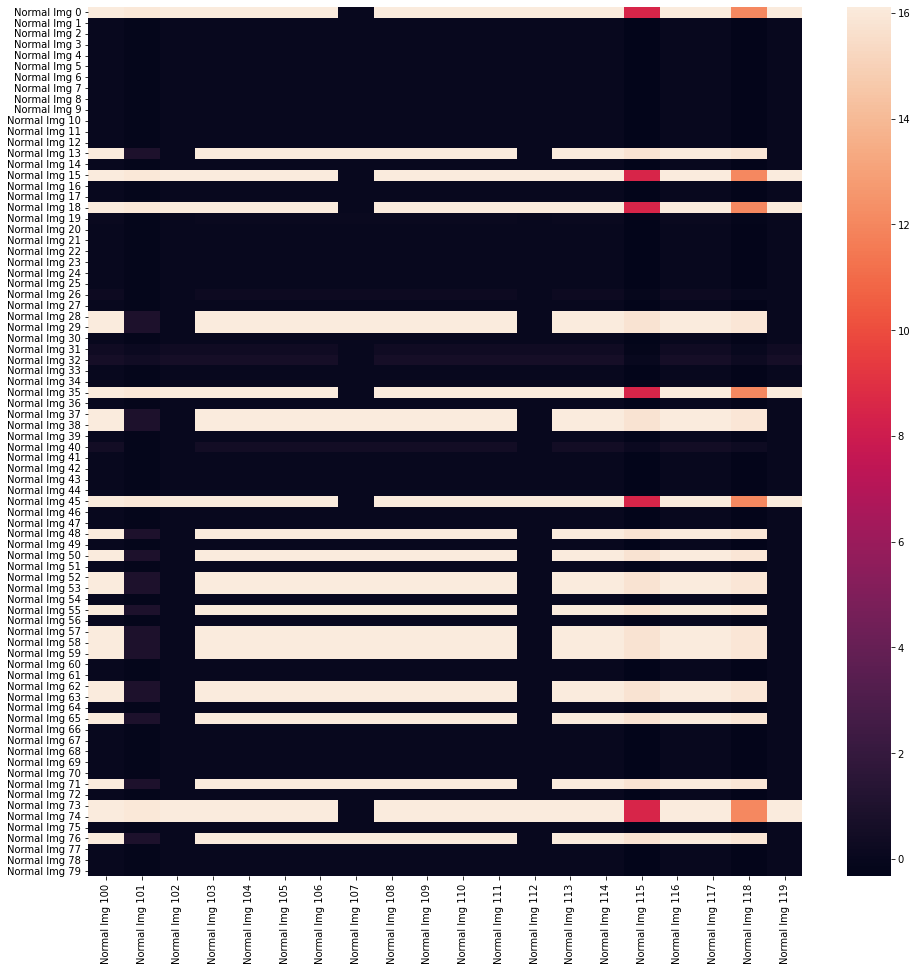

In [106]:
import pandas as pd

normal_df = pd.DataFrame(np.array(kld_test_normal).reshape(80,20), columns=['Normal Img ' + str(i) for i in range(100,120)], index=['Normal Img ' + str(i) for i in range(0,80)])
anomaly_df = pd.DataFrame(np.array(kld_test_anomaly).reshape(80,20), columns=['Anomaly Img ' + str(i) for i in range(100,120)], index=['Normal Img ' + str(i) for i in range(0,80)])

import seaborn as sns
plt.figure(figsize=(16,16))
sns.heatmap(data=normal_df)
plt.show()

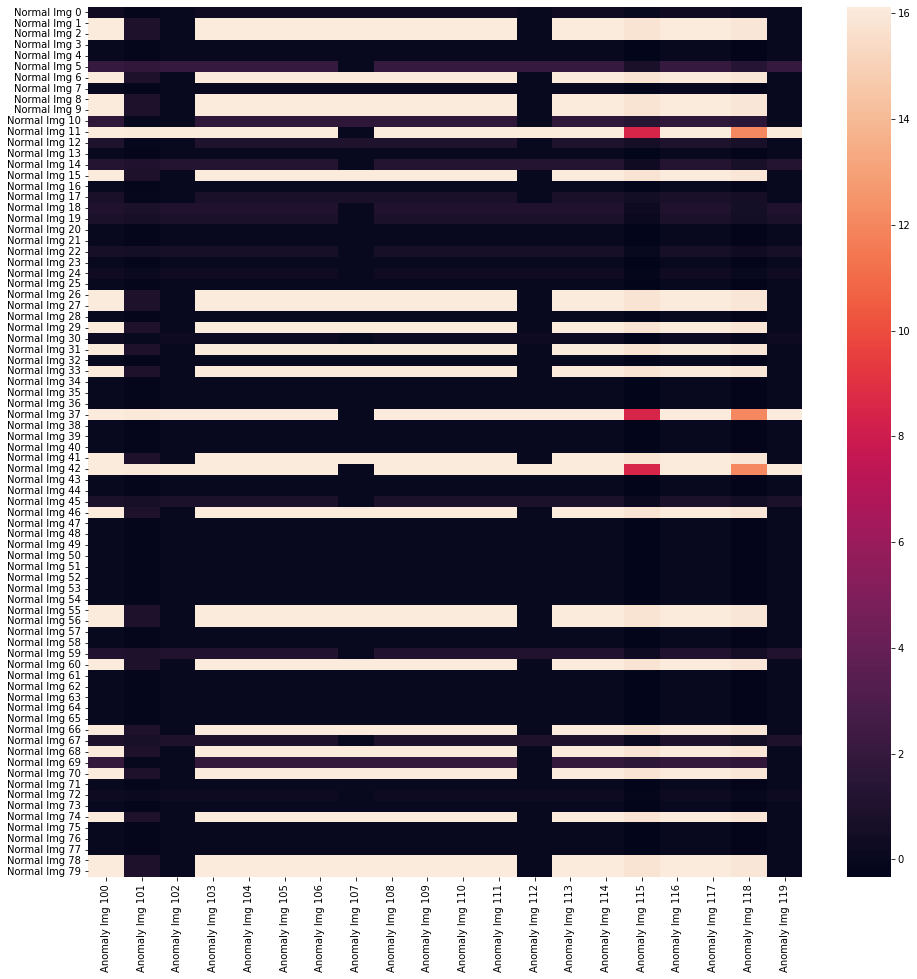

In [107]:
plt.figure(figsize=(16,16))
sns.heatmap(data=anomaly_df)
plt.show()

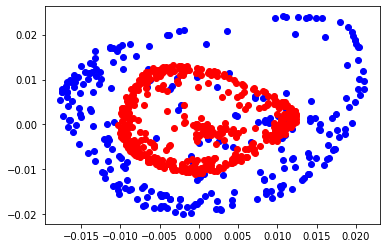

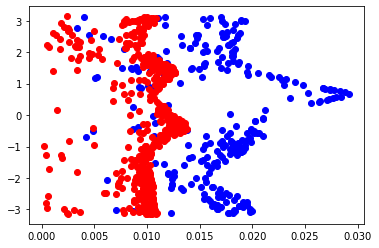

In [64]:
from sklearn.manifold import SpectralEmbedding

iso = SpectralEmbedding(n_components=2, affinity='nearest_neighbors')
X_iso = iso.fit_transform(np.array(anomaly_scores[0]).reshape(-1,10))

iso = SpectralEmbedding(n_components=2, affinity='nearest_neighbors')
X_iso2 = iso.fit_transform(np.array(anomaly_scores[1]).reshape(-1,10))

plt.scatter(X_iso[:,0], X_iso[:,1], color='blue')
plt.scatter(X_iso2[:,0], X_iso2[:,1], color='red')
plt.show()

X_r = np.sqrt(X_iso[:,0]**2 + X_iso[:,1]**2)
X_r2 = np.sqrt(X_iso2[:,0]**2 + X_iso2[:,1]**2)
X_theta = np.arctan2(X_iso[:,0], X_iso[:,1])
X_theta2 = np.arctan2(X_iso2[:,0], X_iso2[:,1])

plt.scatter(X_r, X_theta, color='blue')
plt.scatter(X_r2, X_theta2, color='red')
plt.show()